In [1]:
import numpy as np
import torch
import pandas as pd
import scipy
from scipy.io import loadmat
import seaborn as sns
from tedeous.points_type import *
from matplotlib import cm
from tedeous.input_preprocessing import *
import matplotlib.pyplot as plt
%matplotlib inline
from tedeous.metrics import *
from scipy.interpolate import interp1d
%load_ext autoreload
%autoreload 2

In [2]:
# prepares test data (exact solution)
test_data = loadmat('examples/benchmarking_data/schrodinger_test.mat')
data = test_data['uu'].reshape(-1, 1)
u = np.real(data).reshape(-1)
v = np.imag(data).reshape(-1)

In [3]:
# grid
x_grid = np.linspace(-5,5,256)
t_grid = np.linspace(0,np.pi/2,201)

x = torch.from_numpy(x_grid)
t = torch.from_numpy(t_grid)

grid_test = torch.cartesian_prod(x, t).float()

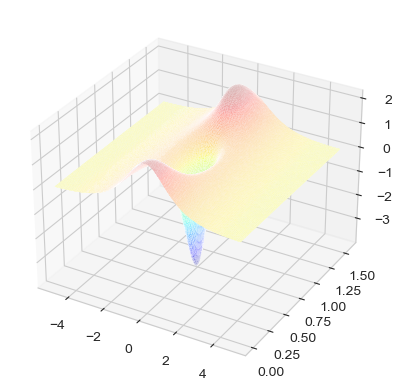

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(grid_test[:, 0].detach().numpy().reshape(-1), grid_test[:, 1].detach().numpy().reshape(-1),
                u, cmap=cm.jet,linewidth=0.2, alpha=1)
plt.savefig('schrod_exact.png')

In [12]:
# transform test data into interpolated values with given grid size and wrap it in pd.dataframe
def interp_test_data(min, max, grid_test, u, v):
    n = np.arange(min, max + 10, 10)
    dct = {'grid': [], 'interpolated_values_u': [], 'interpolated_values_v': []}
    for number in n:
        x_grid = np.linspace(-5, 5, number + 1)
        t_grid = np.linspace(0, np.pi / 2, number + 1)

        x = torch.from_numpy(x_grid)
        t = torch.from_numpy(t_grid)

        grid = torch.cartesian_prod(x, t).float()
        interpolated_values_u = scipy.interpolate.griddata(grid_test, u, grid, method='cubic')
        interpolated_values_v = scipy.interpolate.griddata(grid_test, v, grid, method='cubic')
        N = [number for i in range(len(interpolated_values_u))]
        dct['grid'].extend(N)
        dct['interpolated_values_v'].extend(interpolated_values_v)
        dct['interpolated_values_u'].extend(interpolated_values_u)
    test_data = pd.DataFrame(dct)
    return test_data

def experiment_data_prepare(test_data, experiment_data, min, max):
    experiment_result = {'grid': [], 'n_iter': [], 'rmse_u': [],'rmse_v': [], 'nrmse_u': [], 'time': []}
    for grid in range(min+1,max + 10+1,10):
        for n_iter in range(10):
            test_u = test_data[test_data['grid'] == grid]['interpolated_values_u'].values
            test_v = test_data[test_data['grid'] == grid]['interpolated_values_v'].values
            result_u = experiment_data.query(f'n_iter == {n_iter} and grid == {grid-1}')['u'].values
            result_v = experiment_data.query(f'n_iter == {n_iter} and grid == {grid-1}')['v'].values
            rmse_v = np.sqrt(np.mean((test_v - result_v) ** 2))
            rmse_u = np.sqrt(np.mean((test_u - result_u) ** 2))
            nrmse_u = rmse_u / np.std(result_u)
            time = experiment_data.query(f'n_iter == {n_iter} and grid == {grid}')['time'].values[0]
            experiment_result['grid'].append(grid+1)
            experiment_result['n_iter'].append(n_iter)
            experiment_result['rmse_v'].append(rmse_v)
            experiment_result['rmse_u'].append(rmse_u)
            experiment_result['nrmse_u'].append(nrmse_u)
            experiment_result['time'].append(time)
    data = pd.DataFrame(experiment_result)
    return data

# def draw_plot(data, min, max, interp, xlabel, ylabel, time = False):
#     x = np.arange(min, max + 10, 10)
#     y = interp
#     f = interp1d(x, y, kind='quadratic')
#     xnew = np.linspace(min ** 2, max ** 2)
#     if time:
#         mean_time = []
#         for g in grd:
#             mean_time.append(np.mean(data.query(f'grid == {g}')['time']))
#         plt.plot(data['grid']*data['grid'], data['time'], marker='o', linestyle='')
#         plt.plot(xnew,f(xnew))
#     else:
#
#     plt.xlabel(f'{xlabel}')
#     plt.ylabel(f'{ylabel}')

In [130]:
schrodinger_cache_false = pd.read_csv(
    'examples/benchmarking_data/schrodinger_experiment_[10, 20, 30, 40]_cache=False.csv')
schrodinger_cache_true = pd.read_csv(
    'examples/benchmarking_data/schrodinger_experiment_[10, 20, 30, 40, 50]_cache=True.csv')
schrodinger_weak_cache_false = pd.read_csv(
    'examples/benchmarking_data/schrodinger_weak_experiment_[10, 20, 30, 40, 50]_cache=False.csv')

In [150]:
experiment_data = schrodinger_cache_true

In [151]:
n = [10, 20, 30, 40, 50]
dct = {'grid': [], 'interpolated_values_u': [], 'interpolated_values_v': []}
for number in n:
    x_grid = np.linspace(-5, 5, number + 1)
    t_grid = np.linspace(0, np.pi / 2, number + 1)

    x = torch.from_numpy(x_grid)
    t = torch.from_numpy(t_grid)

    grid = torch.cartesian_prod(x, t).float()
    interpolated_values_u = scipy.interpolate.griddata(grid_test, u, grid, method='cubic')
    interpolated_values_v = scipy.interpolate.griddata(grid_test, v, grid, method='cubic')
    N = [number for i in range(len(interpolated_values_u))]
    dct['grid'].extend(N)
    dct['interpolated_values_v'].extend(interpolated_values_v)
    dct['interpolated_values_u'].extend(interpolated_values_u)
test_data = pd.DataFrame(dct)

In [152]:
experiment_result = {'grid': [], 'n_iter': [], 'rmse_u': [],'rmse_v': [], 'nrmse_u': [], 'time': []}
for grid in range(10,60,10):
    for n_iter in range(10):
        test_u = test_data[test_data['grid'] == grid]['interpolated_values_u'].values
        test_v = test_data[test_data['grid'] == grid]['interpolated_values_v'].values
        result_u = experiment_data.query(f'n_iter == {n_iter} and grid == {grid}')['u'].values
        result_v = experiment_data.query(f'n_iter == {n_iter} and grid == {grid}')['v'].values
        rmse_v = np.sqrt(np.mean((test_v - result_v) ** 2))
        rmse_u = np.sqrt(np.mean((test_u - result_u) ** 2))
        nrmse_u = rmse_u / np.std(result_u)
        time = experiment_data.query(f'n_iter == {n_iter} and grid == {grid}')['time'].values[0]
        experiment_result['grid'].append(grid+1)
        experiment_result['n_iter'].append(n_iter)
        experiment_result['rmse_v'].append(rmse_v)
        experiment_result['rmse_u'].append(rmse_u)
        experiment_result['nrmse_u'].append(nrmse_u)
        experiment_result['time'].append(time)
data = pd.DataFrame(experiment_result)

In [153]:
x = [11**2,21**2,31**2,41**2, 51**2]
grd = [11, 21, 31, 41, 51]
mean_time = []
for g in grd:
    mean_time.append(np.mean(data.query(f'grid == {g}')['time']))
y = mean_time
f = interp1d(x, y, kind='quadratic')
xnew = np.linspace(11**2, 51**2)

In [154]:
h = np.sqrt(data['rmse_v']**2 + data['rmse_u']** 2)
h_mean = list(set(h))

In [160]:
test_data[test_data['grid'] == 10]['interpolated_values_u'].values

array([ 0.02695056,  0.03260382,  0.03420716,  0.03475574,  0.03492699,
        0.034309  ,  0.03360063,  0.03225105,  0.03112513,  0.02763927,
        0.02636017,  0.07295037,  0.07319679,  0.069523  ,  0.06700413,
        0.06497201,  0.06289575,  0.06013422,  0.05698216,  0.05429713,
        0.05016175,  0.04734092,  0.19711746,  0.1959615 ,  0.19299055,
        0.19102151,  0.1856891 ,  0.17916657,  0.17192488,  0.16365532,
        0.15508521,  0.14466002,  0.13431266,  0.52562333,  0.51784725,
        0.49690626,  0.47210287,  0.44857975,  0.43657531,  0.4349855 ,
        0.43444197,  0.42871452,  0.40757898,  0.37171966,  1.28071124,
        1.19795536,  0.97999627,  0.71583666,  0.52882028,  0.52176611,
        0.69010228,  0.92236583,  1.08294288,  1.08007742,  0.90557495,
        1.99958073,  1.76528341,  0.98348639, -0.58226342, -2.94717013,
       -3.68001601, -0.72895298,  1.52340548,  2.18368684,  2.02259221,
        1.41672212,  1.31929761,  1.22996009,  0.99357603,  0.70

In [159]:
experiment_data.query(f'n_iter == {0} and grid == {10}')['u'].values

array([0.03318459, 0.03364766, 0.03383517, 0.03371757, 0.03333873,
       0.03277451, 0.03209615, 0.03135902, 0.03058606, 0.02976841,
       0.02887165, 0.06677186, 0.0662002 , 0.06538975, 0.06419384,
       0.06257016, 0.06053555, 0.05812705, 0.05538708, 0.05234408,
       0.04901552, 0.04540801, 0.19914597, 0.19753951, 0.19376087,
       0.18795174, 0.18044549, 0.17166328, 0.1620211 , 0.15187168,
       0.14147574, 0.13100529, 0.1205551 , 0.53122693, 0.5263576 ,
       0.51017344, 0.48611838, 0.4573524 , 0.42635652, 0.39483088,
       0.36379468, 0.33378702, 0.3050524 , 0.27769578, 1.2959943 ,
       1.2217739 , 1.102437  , 0.9716155 , 0.84660417, 0.73378575,
       0.6343204 , 0.5473268 , 0.47129452, 0.4046528 , 0.3459738 ,
       1.9998935 , 1.7474546 , 1.4606155 , 1.2012131 , 0.98350954,
       0.8049571 , 0.65894085, 0.53882533, 0.43902826, 0.3551675 ,
       0.28390872, 1.2962596 , 1.2283022 , 1.1240777 , 1.007602  ,
       0.89247227, 0.7849685 , 0.6873623 , 0.5999695 , 0.52222

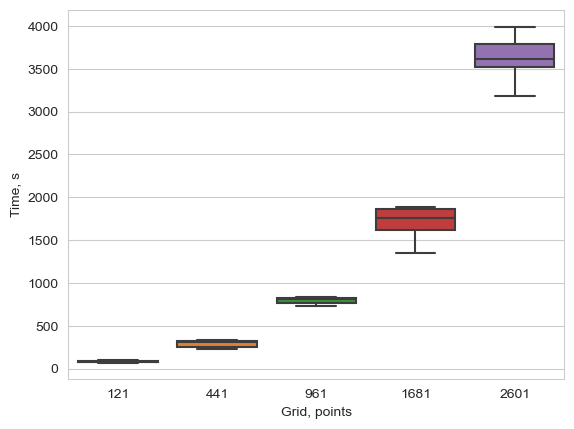

In [149]:
sns.boxplot(x=data['grid']*data['grid'], y=data['time'] , showfliers=False)
plt.xlabel('Grid, points')
plt.ylabel('Time, s')
plt.savefig('schrodinger_weak_cache_false_time.png')

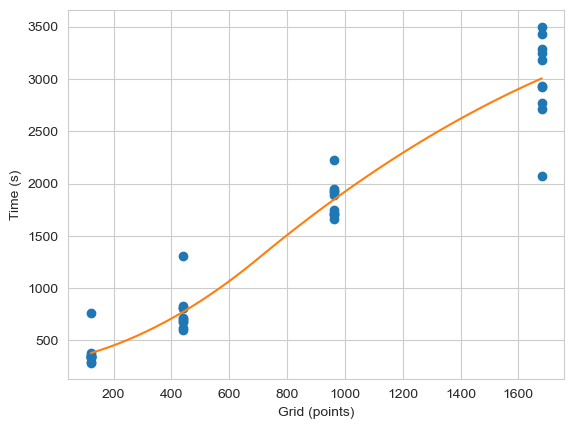

In [135]:
plt.plot(data['grid']*data['grid'], data['time'], marker='o', linestyle='')
plt.plot(xnew,f(xnew))
plt.xlabel('Grid (points)')
plt.ylabel('Time (s)')
plt.savefig('schrodinger_cache_false_time.png', dpi=150)
## schrodinger cache = True


In [27]:
h = np.sqrt(data['rmse_v']**2 + data['rmse_u']** 2)
h_mean = list(set(h))

In [39]:
from scipy import interpolate

In [79]:
x1 = [11**2,21**2,31**2,41**2,51**2]
y1 = h_mean
tck = interpolate.splrep(x1,y1,s=5, k= 3)
xnew1 = np.linspace(11**2, 51**2)
yfit = interpolate.splev(xnew1, tck,der=0)

Text(0, 0.5, '$RMSE_h$')

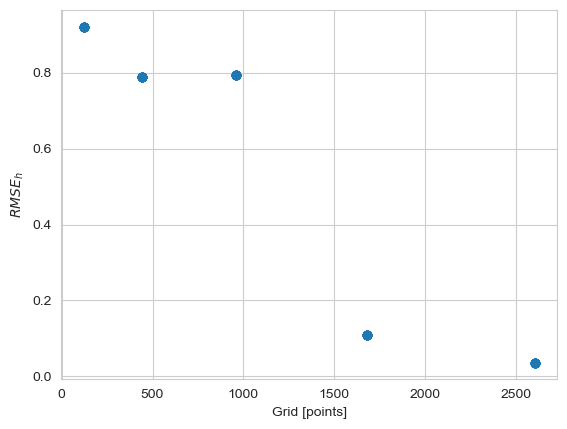

In [82]:
plt.plot(data['grid']*data['grid'], h, marker='o', linestyle='' )
# plt.plot(xnew1,yfit)
plt.xlabel('Grid [points]')
plt.ylabel('$RMSE_h$')

<AxesSubplot:xlabel='grid'>

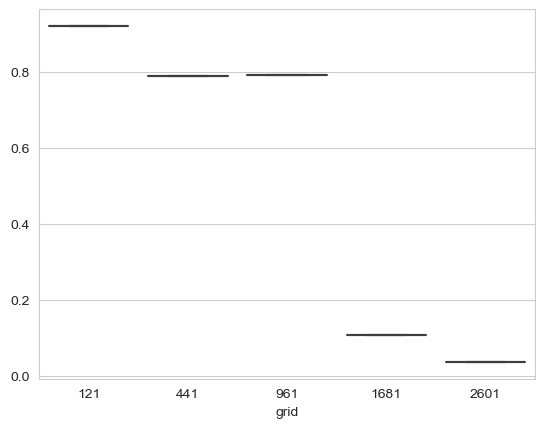

In [81]:
# fig, axes = plt.subplots(1, 3)

sns.boxplot(x=data['grid']*data['grid'], y=h , showfliers=False)
# sns.boxplot(ax=axes[1],x='grid', y='rmse_u', data=data, showfliers=False)
# sns.boxplot(ax=axes[2],x='grid', y='rmse_v', data=data, showfliers=False)

In [50]:
num = 50

In [51]:
x_grid = np.linspace(-5,5,num+1)
t_grid = np.linspace(0,np.pi/2,num+1)

x = torch.from_numpy(x_grid)
t = torch.from_numpy(t_grid)

grid_test = torch.cartesian_prod(x, t).float()
# model_interp = test_data[test_data['grid'] == 10]['interpolated_values_u'].values

In [52]:
V = experiment_data.query(f'n_iter == {6} and grid == {num}')['v'].values

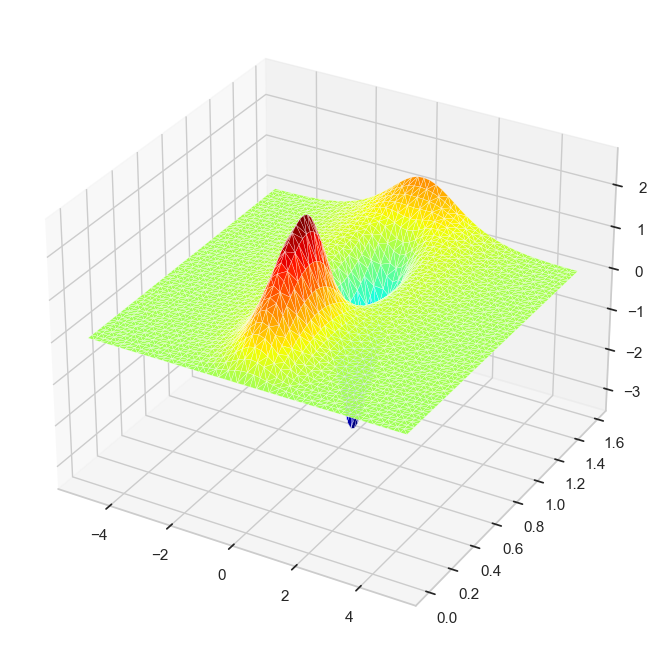

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(grid_test[:, 0].detach().numpy().reshape(-1), grid_test[:, 1].detach().numpy().reshape(-1),
                V, cmap=cm.jet,linewidth=0.2, alpha=1)